# Import functions for all processing
Put this notebook inside passive_interval_oddball_202412 project folder. The fllowing is the same as main.py at the beginning.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import argparse
from datetime import datetime

from modules import Trialization
from modules.ReadResults import read_ops

def combine_session_config_list(session_config_list):
    list_session_data_path = []
    for sc in session_config_list['list_config']:
        list_session_data_path += [
            os.path.join('results', sc['session_folder'], n)
            for n in sc['list_session_name'].keys()]
    list_session_name = [sc['list_session_name'] for sc in session_config_list['list_config']]
    list_session_name = {k: v for d in list_session_name for k, v in d.items()}
    session_config_list['list_session_name'] = list_session_name
    session_config_list['list_session_data_path'] = list_session_data_path
    return session_config_list

# Define the folder name to the sessions you want to process

## Folder structure

This notebook should be SomeWhere/passive_interval_oddball_202412/quick_start.ipynb.

The data should be SomeWhere/passive_interval_oddball_202412/SubjectName/SessionName.

In this example, we use 1 session from the random paradigm, and the session data is SomeWhere/passive_interval_oddball_202412/test/VTYH02_PPC_20250109_3331Random.

## How to set the sessions going into the analysis

Change list_session_name elements in session_config_test to add or exclude sessions. No need to change anything else at this time.

## It works for both single and cross subject analysis

Here, session_config_test is for cross subject analysis, while session_config_list_test specify the info for one subject. If you are running single subject analysis, list_config in session_config_list_test should have only 1 element for that subject.

## Using short long session as example below

In [2]:
session_config_test = {
        'list_session_name' : {
            'YH18VT_V1_20250417_1451ShortLong' : 'short_long',
            'YH18VT_V1_20250418_1451ShortLong' : 'short_long',
            'YH18VT_V1_20250421_1451ShortLong' : 'short_long',
            },
        'session_folder' : 'YH18VT',
        'sig_tag' : 'all',
        'force_label' : None,
        }
session_config_list_test = {
    'list_config': [
        session_config_test,
        ],
    'label_names' : {
        '-1':'Exc',
        '1':'Inh_VIP',
        '2':'Inh_SST',
        },
    'subject_name' : 'YH18VT',
    'output_filename' : 'YH18VT_PPC_passive.html'
    }

Read all saved processsed results.

Set other useful variables.

In [3]:
cate_list = [[-1,1,2]]

import matplotlib.pyplot as plt

label_names = {'-1':'Exc', '1':'Inh_VIP', '2':'Inh_SST'}
cate = [-1,1,2]
roi_id = None
norm_mode='none'
cluster_cmap = plt.cm.hsv
standard = 1
oddball = 1
block = 0
mode = 'post'
temp_folder = 'temp_'+session_config_list_test['subject_name']
if not os.path.exists(os.path.join('results', 'temp_'+session_config_list_test['subject_name'])):
    os.makedirs(os.path.join('results', 'temp_'+session_config_list_test['subject_name']))

Run this to get session configurations. There is only 1 session so the list will have only 1 element. The list structure is using for cross session or cross subject settings.

In [4]:
session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
print(session_config_list)
print(f'number of sessions: {len(list_ops)}')

{'list_config': [{'list_session_name': {'YH18VT_V1_20250417_1451ShortLong': 'short_long', 'YH18VT_V1_20250418_1451ShortLong': 'short_long', 'YH18VT_V1_20250421_1451ShortLong': 'short_long'}, 'session_folder': 'YH18VT', 'sig_tag': 'all', 'force_label': None}], 'label_names': {'-1': 'Exc', '1': 'Inh_VIP', '2': 'Inh_SST'}, 'subject_name': 'YH18VT', 'output_filename': 'YH18VT_PPC_passive.html', 'list_session_name': {'YH18VT_V1_20250417_1451ShortLong': 'short_long', 'YH18VT_V1_20250418_1451ShortLong': 'short_long', 'YH18VT_V1_20250421_1451ShortLong': 'short_long'}, 'list_session_data_path': ['results\\YH18VT\\YH18VT_V1_20250417_1451ShortLong', 'results\\YH18VT\\YH18VT_V1_20250418_1451ShortLong', 'results\\YH18VT\\YH18VT_V1_20250421_1451ShortLong']}
number of sessions: 3


# Reading data results

Run the following to do trialization if it is not done yet. Otherwise, you can skip this.

In [5]:
for i in range(len(list_ops)):
    Trialization.run(list_ops[i])

Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data
Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data
Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data


Now you can read all results for analysis as follows. If you want to smooth the trace, set smooth=True instead.

In [6]:
from modules.ReadResults import read_all
[list_labels, list_masks,list_neural_trials, list_move_offset] = read_all(session_config_list, smooth=False)

Reading subject 1/1


100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  5.02it/s]


# Define utility functions

All the following codes are drawed from utils.py. No need to go through the details.



In [11]:
from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import clustering_neu_response_mode
from modeling.clustering import remap_cluster_id
from modeling.generative import run_glm_multi_sess
from modeling.quantifications import fit_trf_model

# compute mean and sem for 3d array data.
def get_mean_sem(data, win_baseline=None):
    # compute mean.
    m = np.nanmean(data.reshape(-1, data.shape[-1]), axis=0)
    # compute sem.
    std = np.nanstd(data.reshape(-1, data.shape[-1]), axis=0)
    count = np.nansum(~np.isnan(data.reshape(-1, data.shape[-1])), axis=0)
    s = std / np.sqrt(count)
    return m, s

# compute indice with givn time window for dF/F.
def get_frame_idx_from_time(timestamps, c_time, l_time, r_time):
    l_idx = np.searchsorted(timestamps, c_time+l_time)
    r_idx = np.searchsorted(timestamps, c_time+r_time)
    return l_idx, r_idx

def run_glm():
    # define kernel window.
    kernel_win = [-1500,1500]
    l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, kernel_win[0], kernel_win[1])
    kernel_time = alignment['neu_time'][l_idx:r_idx]
    l_idx = np.searchsorted(alignment['neu_time'], 0) - l_idx
    r_idx = r_idx - np.searchsorted(alignment['neu_time'], 0)
    # collect data.
    list_dff = [nt['dff'] for nt in list_neural_trials]
    list_neu_time = [nt['time'] for nt in list_neural_trials]
    list_input_time  = [nt['vol_time'] for nt in list_neural_trials]
    list_input_value = [nt['vol_stim_vis'] for nt in list_neural_trials]
    list_stim_labels = [nt['stim_labels'] for nt in list_neural_trials]
    # fit glm model.
    kernel_all = run_glm_multi_sess(
        list_dff, list_neu_time,
        list_input_time, list_input_value, list_stim_labels,
        l_idx, r_idx)
    glm = {
        'kernel_time': kernel_time,
        'kernel_all': kernel_all,
        }
    return glm

def run_clustering( n_pre, n_post):
    r2_thres = 0.4
    # get data within range.
    z_idx = get_frame_idx_from_time(glm['kernel_time'], 0, 0, 0)[0]
    neu_seq_l = glm['kernel_all'][:,:z_idx]
    neu_time_l = glm['kernel_time'][:z_idx]
    neu_seq_r = glm['kernel_all'][:,z_idx:]
    neu_time_r = glm['kernel_time'][z_idx:]
    # fit response model.
    [trf_param_pre, pred_pre, r2_pre,
     trf_param_post, pred_post, r2_post] = fit_trf_model(
         neu_seq_l, neu_time_l, neu_seq_r, neu_time_r)
    trf_model = {
        'trf_param_pre': trf_param_pre,
        'pred_pre': pred_pre,
        'r2_pre': r2_pre,
        'trf_param_post': trf_param_post,
        'pred_post': pred_post,
        'r2_post': r2_post}
    # initilize clustering.
    n_clusters = n_pre + n_post
    cluster_id = np.ones(glm['kernel_all'].shape[0]) * -1
    # get good ramp index.
    idx_pre = (r2_pre > r2_thres) * (r2_pre > r2_post)
    idx_post = (r2_post > r2_thres) * (r2_post > r2_pre)
    # run clustering.
    cluster_id_pre = clustering_neu_response_mode(trf_param_pre[idx_pre,3].reshape(-1,1), n_pre, 'kmeans')
    cluster_id_post = clustering_neu_response_mode(trf_param_post[idx_post,3].reshape(-1,1), n_post, 'kmeans')
    # relabel based on temporal receptive field.
    sorted_pre = np.argsort([np.nanmean(trf_param_pre[idx_pre,3][cluster_id_pre==ci]) for ci in range(n_pre)])
    sorted_post = np.argsort([np.nanmean(trf_param_post[idx_post,3][cluster_id_post==ci]) for ci in range(n_post)])
    map_pre = {val: i for i, val in enumerate(sorted_pre)}
    map_post = {val: i for i, val in enumerate(sorted_post)}
    cluster_id_pre = np.vectorize(map_pre.get)(cluster_id_pre)
    cluster_id_post = np.vectorize(map_post.get)(cluster_id_post)
    cluster_id[idx_pre] = cluster_id_pre
    cluster_id[idx_post] = cluster_id_post+n_pre
    return cluster_id

In [58]:
def plot_cluster_mean_sem(
            ax, neu_mean, neu_sem, neu_time,
            norm_params, stim_seq, c_stim, c_neu, xlim,
            scale_bar=True
            ):
    gap = 0.05
    l_nan_margin = 5
    r_nan_margin = 5
    len_scale_y = 0.5
    # set margin values to nan.
    l_idx, r_idx = get_frame_idx_from_time(neu_time, 0, xlim[0], xlim[1])
    nm = neu_mean.copy()
    ns = neu_sem.copy()
    nm[:,:l_idx+l_nan_margin] = np.nan
    nm[:,r_idx-r_nan_margin-1:] = np.nan
    ns[:,:l_idx+l_nan_margin] = np.nan
    ns[:,r_idx-r_nan_margin-1:] = np.nan
    # plot stimulus.
    if not stim_seq is None:
        for si in range(stim_seq.shape[0]):
            if stim_seq[si,0] >= xlim[0] and stim_seq[si,1] <= xlim[1]:
                ax.fill_between(
                    stim_seq[si,:],
                    0, nm.shape[0],
                    color=c_stim[si], edgecolor='none', alpha=0.25, step='mid')
    # plot cluster average.
    for ci in range(n_clusters):
        a, b, c, d = norm_params[ci]
        # add y=0 line.
        #ax.hlines(ci+b, xlim[0]*0.99, xlim[1]*0.99, linestyle=':', color='#2C2C2C', alpha=0.2)
        # plot neural traces.
        plot_mean_sem(
            ax, neu_time,
            (a*nm[ci,:]+b)*(1-2*gap)+gap+n_clusters-ci-1, np.abs(a)*ns[ci,:],
            c_neu[ci], None)
        # plot y scalebar.
        if scale_bar:
            y_start = ci + 0.5 - len_scale_y/2
            ax.vlines(xlim[0]*0.99, y_start, y_start+len_scale_y, color='#2C2C2C')
            ax.text(xlim[0]*0.99, ci+0.5,
                '{:.3f}'.format(len_scale_y*(d-c)),
                va='center', ha='right', rotation=90, color='#2C2C2C')
    # plot x scalebar.
    if scale_bar:
        ax.set_ylim([-0.2, neu_mean.shape[0]+0.1])
    # adjust layouts.
    adjust_layout_cluster_neu(ax, nm.shape[0], xlim)

def plot_glm_kernel(ax, kernel_all, cluster_id, color, height):
    gap = 0.05
    # define layouts.
    ax.axis('off')
    ax_lbl = ax.inset_axes([0, 0, 0.4, height], transform=ax.transAxes)
    ax_glm = ax.inset_axes([0.5, 0, 0.5, height], transform=ax.transAxes)
    # get cluster average.
    glm_mean, glm_sem = get_mean_sem_cluster(kernel_all, n_clusters, cluster_id)
    norm_params = [get_norm01_params(glm_mean[ci,:]) for ci in range(n_clusters)]
    # plot results.
    ax_glm.axvline(0, color=color, lw=1, linestyle='--')
    plot_cluster_mean_sem(
        ax_glm, glm_mean, glm_sem, glm['kernel_time'],
        norm_params, None, None, [color]*n_clusters,
        [np.nanmin(glm['kernel_time']), np.nanmax(glm['kernel_time'])])
    # adjust layouts.
    ax_lbl.spines['right'].set_visible(False)
    ax_lbl.spines['top'].set_visible(False)
    ax_lbl.spines['bottom'].set_visible(False)
    ax_lbl.set_ylim([-0.2, n_clusters+0.1])
    ax_lbl.set_xticks([])
    ax_lbl.set_yticks([(1-2*gap)+gap+n_clusters-ci-1.5 for ci in range(n_clusters)])
    ax_lbl.set_yticklabels(np.arange(n_clusters))
    ax_lbl.set_ylabel('Cluster ID')
    ax_glm.set_xlabel('time since stim (ms)')

# add legend into subplots.
def add_legend(ax, colors, labels, n_trials, n_neurons, n_sessions, loc, dim=2):
    if dim == 2:
        plot_args = [[],[]]
    if dim == 3:
        plot_args = [[],[],[]]
    handles = []
    if colors != None and labels != None:
        handles += [
            ax.plot(*plot_args, lw=0, color=colors[i], label=labels[i])[0]
            for i in range(len(labels))]
    if n_trials != None and n_neurons != None:
        handles += [
            ax.plot(*plot_args, lw=0, color='black', label=r'$n_{trial}=$'+str(n_trials))[0],
            ax.plot(*plot_args, lw=0, color='black', label=r'$n_{neuron}=$'+str(n_neurons))[0],
            ax.plot(*plot_args, lw=0, color='black', label=r'$n_{session}=$'+str(n_sessions))[0]]
    ax.legend(
        loc=loc,
        handles=handles,
        labelcolor='linecolor',
        frameon=False,
        framealpha=0)

In [47]:
# adjust layout for grand average neural traces for clustering.
def adjust_layout_cluster_neu(ax, n_clusters, xlim):
    ax.tick_params(axis='y', tick1On=False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_xticks([0])
    ax.set_yticks([])
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=3))

# Neural data processing

We are using classes for modularizations. All the following codes are drawed from fig5_1451ShortLong.py.

## Import functions and run alignment

This is the same when initiating a plotter class.

In [34]:
import traceback
import numpy as np
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import savgol_filter

from modules.Alignment import run_get_stim_response
from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import get_cluster_cate
from modeling.decoding import decoding_time_confusion
from modeling.decoding import decoding_time_single
from modeling.decoding import regression_time_frac
from modeling.generative import get_glm_cate
from modeling.quantifications import fit_trf_model

from utils import norm01
from utils import show_resource_usage
from utils import get_norm01_params
from utils import get_odd_stim_prepost_idx
from utils import get_mean_sem_win
from utils import get_mean_sem
from utils import get_neu_trial
from utils import get_frame_idx_from_time
from utils import get_split_idx
from utils import get_expect_interval
from utils import get_block_1st_idx
from utils import get_block_transition_idx
from utils import exclude_odd_stim
from utils import get_temporal_scaling_data
from utils import get_cmap_color
from utils import hide_all_axis
from utils import get_random_rotate_mat_3d
from utils import adjust_layout_isi_example_epoch
from utils import adjust_layout_neu
from utils import adjust_layout_3d_latent
from utils import add_legend
from utils import add_heatmap_colorbar
from utils import utils_basic

cate_list = cate_list
n_sess = len(list_neural_trials)
list_labels = list_labels
list_neural_trials = list_neural_trials
alignment = run_get_stim_response(temp_folder, list_neural_trials, expected='none')
list_stim_labels = alignment['list_stim_labels']
list_odd_idx = [
    get_odd_stim_prepost_idx(sl) for sl in list_stim_labels]
expect = np.nanmin(np.array([get_expect_interval(sl) for sl in list_stim_labels]),axis=0)
list_block_start = [get_block_1st_idx(sl, 3) for sl in list_stim_labels]
bin_win = [450,2550]
bin_num = 2
d_latent = 3
glm = run_glm()
n_pre = 2
n_post = 3
cluster_id = run_clustering(n_pre, n_post)

Aligning trials for session 1/3


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 20481.21it/s]


Aligning trials for session 2/3


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 17636.12it/s]


Aligning trials for session 3/3


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 21629.42it/s]


Fitting GLM for session 1/3


neurons: 100%|█████████████████████████████| 200/200 [00:00<00:00, 1082.55it/s]


Fitting GLM for session 2/3


neurons: 100%|█████████████████████████████| 254/254 [00:00<00:00, 1029.51it/s]


Fitting GLM for session 3/3


neurons: 100%|█████████████████████████████| 116/116 [00:00<00:00, 1011.44it/s]


Fitting pre ramp model


100%|████████████████████████████████████████████| 5/5 [00:03<00:00,  1.62it/s]


Fitting post ramp model


100%|████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]

Running clustering
Running clustering


In [35]:
n_clusters = n_pre + n_post

All the trialized neural data are in alignment. It has the following keys to access. Each element in alignment is a list. This list has the results for multiple sessions. 

## Neural data
list_neu_seq is the neural data after alignment on each image onset. It has l_frames before the onset and r_frames after onset. Each element in this list represents 1 session, and has the shape of $n_{trials} \times n_{neurons} \times n_{times}$.

neu_time is the time stamps of the neural data with the shape of $n_{times}$.

In [36]:
print('shape of aligned neural data in a session: {}'.format([lns.shape for lns in alignment['list_neu_seq']]))
print('shape of aligned neural timestamps in a session: {}'.format(alignment['neu_time'].shape))

shape of aligned neural data in a session: [(1990, 200, 600), (1990, 254, 600), (1990, 116, 600)]
shape of aligned neural timestamps in a session: (600,)


## Image trial data

list_stim_labels is for accessing trial specific neural data. It marks the information for each image (trial). Each row represents 1 image.

* row 0: stim start.
* row 1: stim end.
* row 2: img_seq_label.
* row 3: standard_types.
* row 4: fix_jitter_types.
* row 5: oddball_types.
* row 6: random_types.
* row 7: opto_types.

Now show the first 5 image here.

In [37]:
print(alignment['list_stim_labels'][0][:5,:])

[[29937 30135     5     0     1     0     1     0]
 [31937 32135     5     0     1     0     1     0]
 [34470 34669     4     0     1     0     1     0]
 [35870 36069     2     0     1     0     1     0]
 [36870 37069     4     0     1     0     1     0]]


The stimulus timing for one trial has been already proceesed in list_stim_seq. It has multiple stimulus onset and end before and after the alignment center after trial averaged.

Now show the stimulus timing for the 5th aligned trial. 

In [38]:
print(alignment['list_stim_seq'][0][5,:])

[[-8400 -8202]
 [-6400 -6202]
 [-3867 -3668]
 [-2467 -2268]
 [-1467 -1268]
 [    0   198]
 [ 1200  1398]
 [ 2933  3132]
 [ 3800  3998]
 [ 5933  6132]
 [ 6933  7132]]


The center stimulus index for alignment can be accessed similar as the following. By setting the number around c_idx you can access stimulus before or after it.

In [39]:
stim_seq = alignment['list_stim_seq'][0][5,:]
c_idx = int(stim_seq.shape[0]/2)
print('onset and end of the aligned stimulus: {}'.format(stim_seq[c_idx,:]))
print('onset and end of the stimlus before center: {}'.format(stim_seq[c_idx-1,:]))
print('onset and end of the stimulus after center: {}'.format(stim_seq[c_idx+1,:]))

onset and end of the aligned stimulus: [  0 198]
onset and end of the stimlus before center: [-1467 -1268]
onset and end of the stimulus after center: [1200 1398]


list_pre_isi is the interval between the center image and the one before it.

Now show the interval before the 5th alignment stimulus.

In [40]:
print('isi before image: {}'.format(alignment['list_pre_isi'][0][5]))

isi before image: 1268


# Visualizing clustering results

If only one category of neuron (only excitatory, only VIP, only SST, etc) is needed, change the variable cate to include that category. Now we include all determined cell types. The neuron without significant ramp-up or ramp-down components will be labeled as $-1$.

In [41]:
color0 = 'dimgrey'
color1 = 'dodgerblue'
color2 = 'springgreen'
cluster_id, neu_labels = get_cluster_cate(cluster_id, list_labels, cate)

In [52]:
print(f'shape of cluster_id: {cluster_id.shape}')
print(f'example cluster id: {cluster_id[:20]}')

shape of cluster_id: (487,)
example cluster id: [-1.  2.  2.  3.  2.  2.  2.  0. -1.  2.  0. -1.  0.  3.  0.  0.  3.  1.
 -1.  2.]


## Fitted GLM kernels

Now show the within cluster average of GLM kernels. The result kernel_all has the shape of $n_{neurons} \times n_{times}$

In [45]:
kernel_all = get_glm_cate(glm, list_labels, cate)
print(f'shape of GLM kernel: {kernel_all.shape}')

shape of GLM kernel: (487, 89)


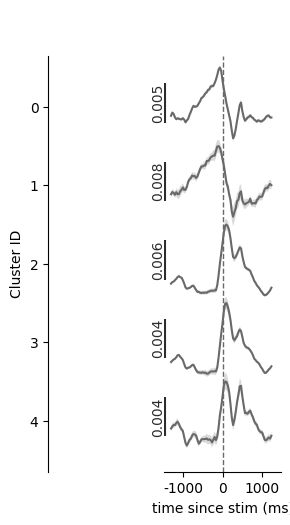

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
plot_glm_kernel(ax, kernel_all, cluster_id, color0, 0.9)

## Response on short/long standard intervals

Now plot the response during short ISI, long ISI, and both superimposed. It is trial averaged, and shows mean/sem across all neurons within clusters. To access the trial data, it is the same as image alignment using get_neu_trial.

In [56]:
# collect data.
[_, [neu_seq_0, _, stim_seq_0, _], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_param=[[2,3,4,5], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)
[_, [neu_seq_1, _, stim_seq_1, _], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_param=[[2,3,4,5], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
c_idx = stim_seq_0.shape[0]//2

print('shape of neural data (short block): {}'.format(neu_seq_0.shape))
print('shape of neural data (long block): {}'.format(neu_seq_1.shape))

shape of neural data (short block): (487, 600)
shape of neural data (long block): (487, 600)


(np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

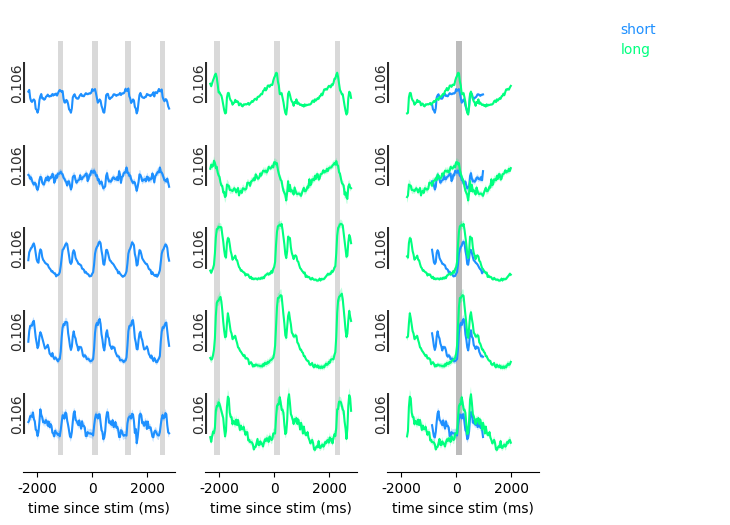

In [62]:
def plot_standard(ax, standard, scaled):
    xlim = [-2500,3000]
    # get response within cluster.
    neu_mean_0, neu_sem_0 = get_mean_sem_cluster(neu_seq_0, n_clusters, cluster_id)
    neu_mean_1, neu_sem_1 = get_mean_sem_cluster(neu_seq_1, n_clusters, cluster_id)
    if scaled:
        norm_params = [get_norm01_params(np.concatenate([neu_mean_0[ci,:], neu_mean_1[ci,:]])) for ci in range(n_clusters)]
    else:
        norm_params = [get_norm01_params(np.concatenate([neu_mean_0, neu_mean_1])) for ci in range(n_clusters)]
    # define layouts.
    ax.axis('off')
    ax = ax.inset_axes([0, 0, 1, 0.95], transform=ax.transAxes)
    # plot results.
    if standard == 0 :
        plot_cluster_mean_sem(
            ax, neu_mean_0, neu_sem_0,
            alignment['neu_time'], norm_params,
            stim_seq_0, [color0]*stim_seq_0.shape[0], [color1]*n_clusters, xlim)
    if standard == 1 :
        plot_cluster_mean_sem(
            ax, neu_mean_1, neu_sem_1,
            alignment['neu_time'], norm_params,
            stim_seq_1, [color0]*stim_seq_1.shape[0], [color2]*n_clusters, xlim)
    if standard == 'both':
        xlim_0 = [stim_seq_0[c_idx-1,1], stim_seq_0[c_idx+1,0]]
        xlim_1 = [stim_seq_1[c_idx-1,1], stim_seq_1[c_idx+1,0]]
        l_0, r_0 = get_frame_idx_from_time(alignment['neu_time'], 0, xlim_0[0], xlim_0[1])
        l_1, r_1 = get_frame_idx_from_time(alignment['neu_time'], 0, xlim_1[0], xlim_1[1])
        neu_mean_0 = neu_mean_0[:,l_0:r_0]
        neu_mean_1 = neu_mean_1[:,l_1:r_1]
        neu_sem_0 = neu_sem_0[:,l_0:r_0]
        neu_sem_1 = neu_sem_1[:,l_1:r_1]
        plot_cluster_mean_sem(
            ax, neu_mean_0, neu_sem_0,
            alignment['neu_time'][l_0:r_0], norm_params,
            stim_seq_0[c_idx,:].reshape(1,2), [color0]*stim_seq_0.shape[0], [color1]*n_clusters, xlim, False)
        plot_cluster_mean_sem(
            ax, neu_mean_1, neu_sem_1,
            alignment['neu_time'][l_1:r_1], norm_params,
            stim_seq_1[c_idx,:].reshape(1,2), [color0]*stim_seq_1.shape[0], [color2]*n_clusters, xlim)
    # adjust layouts.
    ax.set_xlabel('time since stim (ms)')
    ax.set_xlim(xlim)

fig, axs = plt.subplots(1, 4, figsize=(9, 6))
plot_standard(axs[0], 0, False)
plot_standard(axs[1], 1, False)
plot_standard(axs[2], 'both', False)

cs = [color1, color2]
lbl= ['short', 'long']
add_legend(axs[3], cs, lbl, None, None, None, 'upper left')
axs[3].axis('off')

## Response on short long transition

Sometimes you may need trial_idx directly instead of trial_param, as some trials are harder to access. Now plot the cluster response during block transition.

In [66]:
trials_around = 40
# get transition trials indice.
list_trans_0to1 = [get_block_transition_idx(sl[:,3], trials_around)[0] for sl in list_stim_labels]
list_trans_1to0 = [get_block_transition_idx(sl[:,3], trials_around)[1] for sl in list_stim_labels]
list_trans_0to1 = [np.nansum(ti, axis=0).astype('bool') for ti in list_trans_0to1]
list_trans_1to0 = [np.nansum(ti, axis=0).astype('bool') for ti in list_trans_1to0]

In [67]:
xlim = [-7500, 7000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, xlim[0], xlim[1])
# collect data.
[_, [neu_trans_0to1, _, stim_seq_0to1, _], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[1] for l in list_block_start],
    cate=cate, roi_id=None)
[_, [neu_trans_1to0, _, stim_seq_1to0, _], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[0] for l in list_block_start],
    cate=cate, roi_id=None)
neu_time = alignment['neu_time'][l_idx:r_idx]

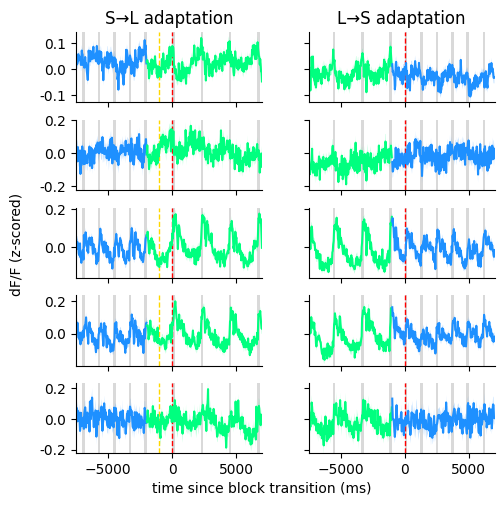

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# define layouts.
ax0 = ax.inset_axes([0.1, 0, 0.4, 0.95], transform=ax.transAxes)
ax1 = ax.inset_axes([0.6, 0, 0.4, 0.95], transform=ax.transAxes)
axs0 = [ax0.inset_axes([0, 0.05+ci/n_clusters, 1, 0.8/n_clusters], transform=ax0.transAxes)
        for ci in range(n_clusters)]
axs1 = [ax1.inset_axes([0, 0.05+ci/n_clusters, 1, 0.8/n_clusters], transform=ax1.transAxes)
        for ci in range(n_clusters)]
axs0.reverse()
axs1.reverse()
# plot results for each class.
for ci in range(n_clusters):
    if np.sum(cluster_id==ci) > 0:
        neu_mean_0to1, neu_sem_0to1 = get_mean_sem(neu_trans_0to1[cluster_id==ci,l_idx:r_idx])
        neu_mean_1to0, neu_sem_1to0 = get_mean_sem(neu_trans_1to0[cluster_id==ci,l_idx:r_idx])
        # find bounds.
        upper = np.nanmax([neu_mean_0to1, neu_mean_1to0])
        lower = np.nanmin([neu_mean_0to1, neu_mean_1to0])
        # plot stimulus.
        for si in range(stim_seq.shape[0]):
            axs0[ci].fill_between(
                stim_seq_0to1[si,:],
                lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
                color=color0, edgecolor='none', alpha=0.25, step='mid')
            axs1[ci].fill_between(
                stim_seq_1to0[si,:],
                lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
                color=color0, edgecolor='none', alpha=0.25, step='mid')
        axs0[ci].axvline(-expect[0], color='gold', lw=1, linestyle='--')
        axs0[ci].axvline(0, color='red', lw=1, linestyle='--')
        axs1[ci].axvline(0, color='red', lw=1, linestyle='--')
        # plot neural traces.
        z_idx_0 = get_frame_idx_from_time(neu_time, 0, stim_seq_1to0[c_idx-1,1], 0)[0]
        z_idx_1 = get_frame_idx_from_time(neu_time, 0, stim_seq_0to1[c_idx-1,1], 0)[0]
        plot_mean_sem(
            axs0[ci], neu_time[:z_idx_1],
            neu_mean_0to1[:z_idx_1], neu_sem_0to1[:z_idx_1], color1, None)
        plot_mean_sem(
            axs0[ci], neu_time[z_idx_1:],
            neu_mean_0to1[z_idx_1:], neu_sem_0to1[z_idx_1:], color2, None)
        plot_mean_sem(
            axs1[ci], neu_time[:z_idx_0],
            neu_mean_1to0[:z_idx_0], neu_sem_1to0[:z_idx_0], color2, None)
        plot_mean_sem(
            axs1[ci], neu_time[z_idx_0:],
            neu_mean_1to0[z_idx_0:], neu_sem_1to0[z_idx_0:], color1, None)
        # adjust layouts.
        adjust_layout_neu(axs0[ci])
        adjust_layout_neu(axs1[ci])
        axs0[ci].set_xlim(xlim)
        axs1[ci].set_xlim(xlim)
        axs0[ci].set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
        axs1[ci].set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
        axs0[ci].set_ylabel(None)
        axs1[ci].set_ylabel(None)
        if ci != n_clusters-1:
            axs0[ci].set_xticklabels([])
            axs1[ci].set_xticklabels([])
        axs1[ci].set_yticklabels([])
ax.set_xlabel('time since block transition (ms)')
ax.set_ylabel('dF/F (z-scored)')
ax0.set_title('S\u2192L adaptation')
ax1.set_title('L\u2192S adaptation')
hide_all_axis(ax)
hide_all_axis(ax0)
hide_all_axis(ax1)